#### Importing Necessary Libraries

In [78]:
import pandas
import math
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
plt.style.use('fivethirtyeight')

#### Fetching Data

In [79]:
# Fetch Tesla stock data
tesla = yf.Ticker("TSLA")

# Get historical data for the last 1 years until today
start_date = (datetime.today() - timedelta(days=3*365)).strftime("%Y-%m-%d")
end_date = datetime.today().strftime("%Y-%m-%d")

df = tesla.history(start=start_date, end=end_date)

print(df.head())
print(df.shape)

                                 Open        High         Low       Close  \
Date                                                                        
2022-02-24 00:00:00-05:00  233.463333  267.493347  233.333328  266.923340   
2022-02-25 00:00:00-05:00  269.743347  273.166656  260.799988  269.956665   
2022-02-28 00:00:00-05:00  271.670013  292.286682  271.570007  290.143341   
2022-03-01 00:00:00-05:00  289.893341  296.626678  284.593323  288.123322   
2022-03-02 00:00:00-05:00  290.709991  295.493347  281.423340  293.296661   

                              Volume  Dividends  Stock Splits  
Date                                                           
2022-02-24 00:00:00-05:00  135322200        0.0           0.0  
2022-02-25 00:00:00-05:00   76067700        0.0           0.0  
2022-02-28 00:00:00-05:00   99006900        0.0           0.0  
2022-03-01 00:00:00-05:00   74766900        0.0           0.0  
2022-03-02 00:00:00-05:00   74643300        0.0           0.0  
(751, 7)


In [80]:
# Checking Null Data
print(df.isnull().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [81]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

### Time Series Plots

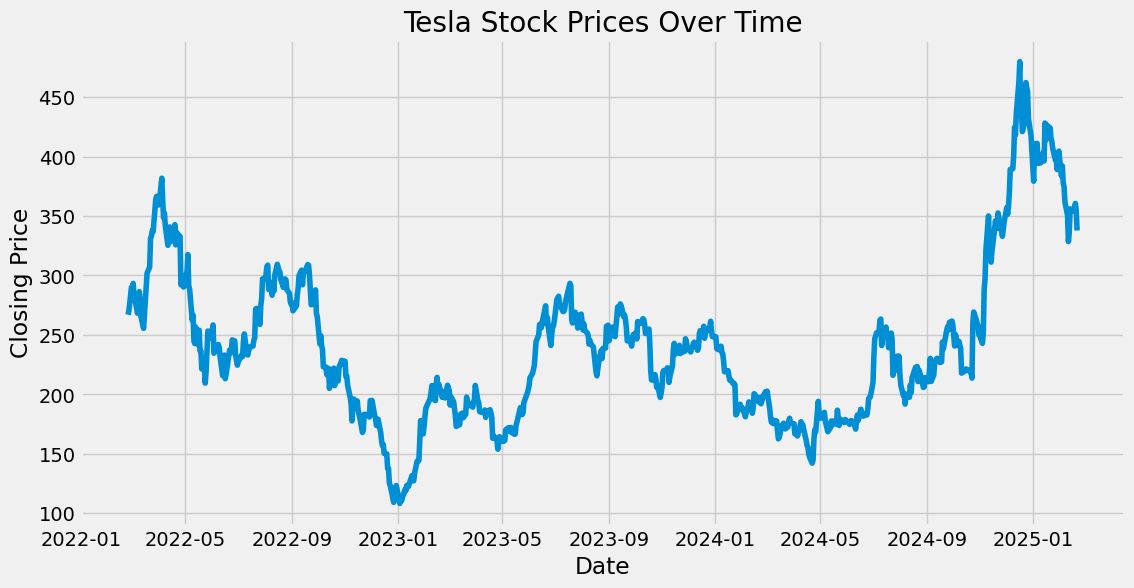

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Tesla Stock Prices Over Time')
plt.show()

### Trend Analysis Using Simple MOving Average

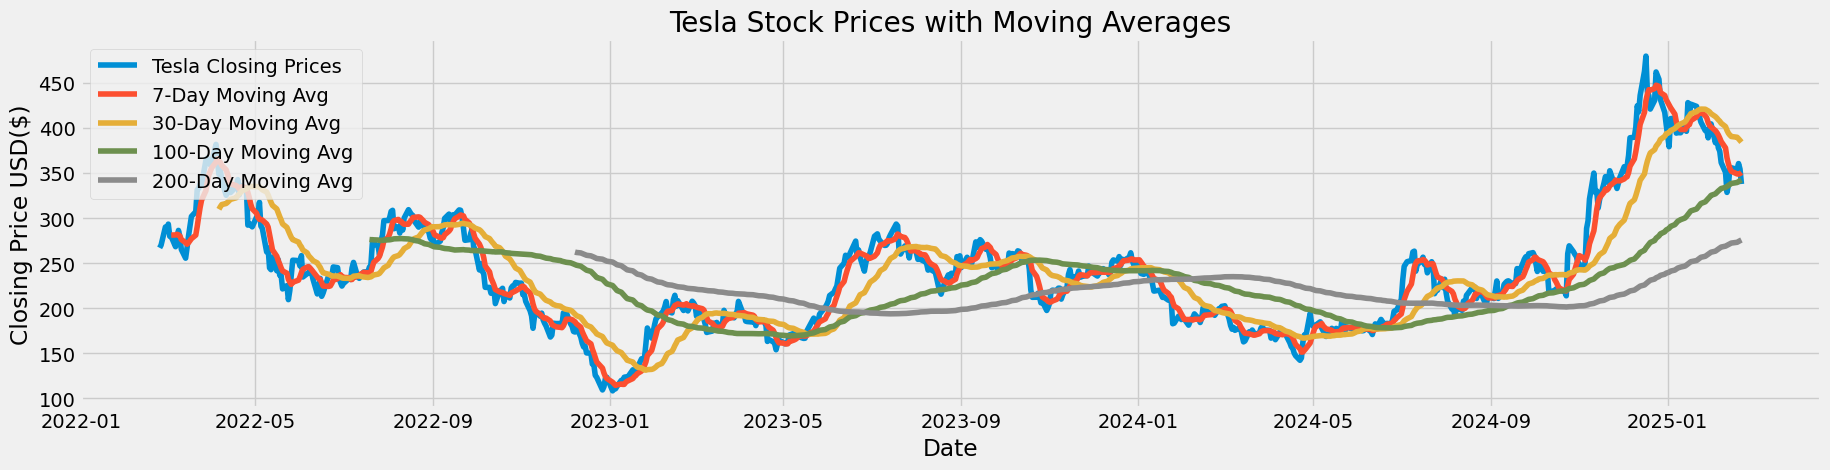

In [83]:
#Visualize the data
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Tesla Closing Prices')
plt.plot(df.index, df['Close'].rolling(window=7).mean(), label='7-Day Moving Avg')
plt.plot(df.index, df['Close'].rolling(window=30).mean(), label='30-Day Moving Avg')
plt.plot(df.index, df['Close'].rolling(window=100).mean(), label='100-Day Moving Avg')
plt.plot(df.index, df['Close'].rolling(window=200).mean(), label='200-Day Moving Avg')

plt.xlabel('Date')
plt.ylabel('Closing Price USD($)')
plt.title('Tesla Stock Prices with Moving Averages')
plt.legend(loc='upper left')
plt.show()

### Volatility Analysis with Bollinger Bands:

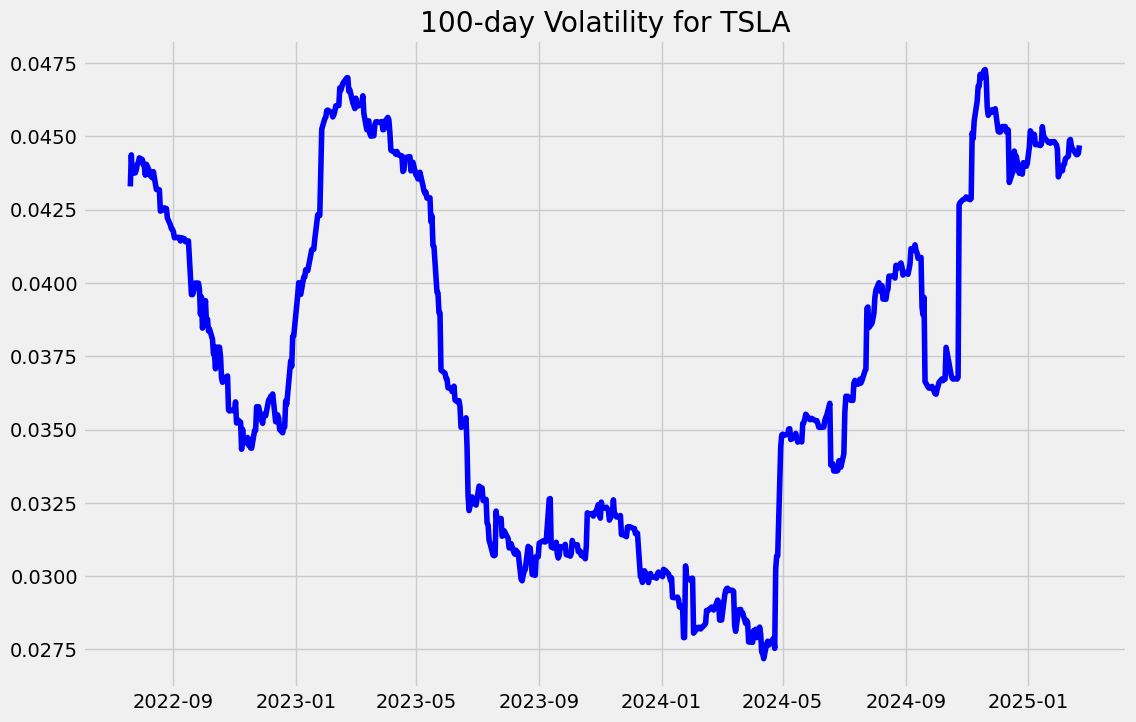

In [84]:
# Calculate daily returns
df['Daily_Returns'] = df['Close'].pct_change()

# Calculate 100-day volatility (standard deviation of returns)
volatility = df['Daily_Returns'].rolling(window=100).std()

# Plotting the volatility
plt.figure(figsize=(12, 8))
plt.plot(volatility, color='blue')
plt.title(f'100-day Volatility for TSLA')
plt.show()

### Seasonality Analysis

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_51740\240344098.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['Close'].resample('M').mean()


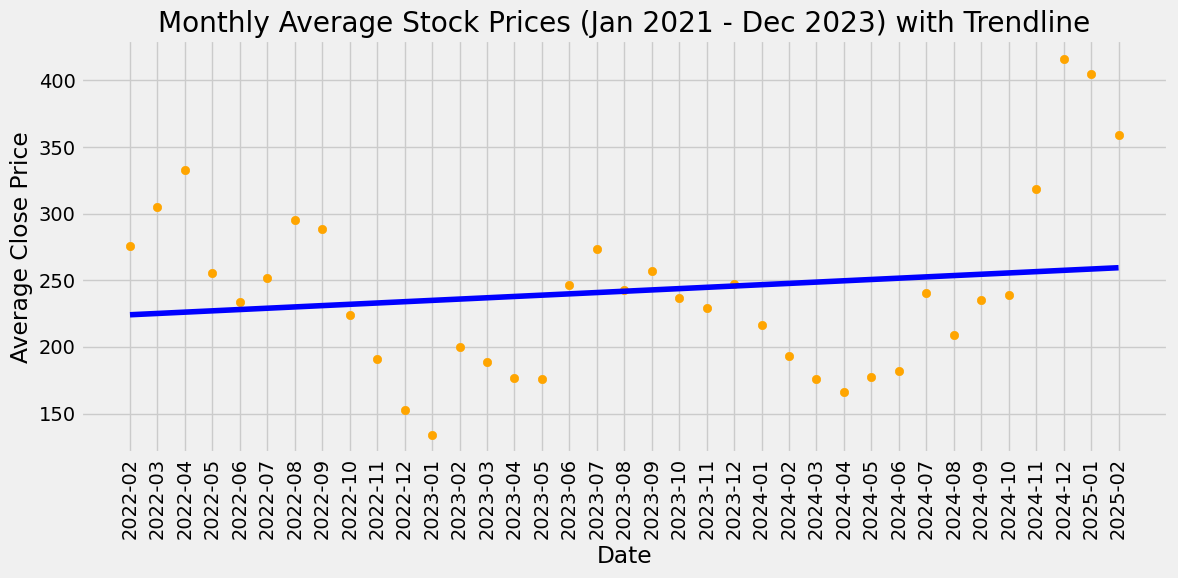

In [85]:
import seaborn as sns
import numpy as np

# Resample the data to get monthly averages
monthly_avg = df['Close'].resample('M').mean()

# Extracting month and year for scatter plot
monthly_avg.index = monthly_avg.index.strftime('%Y-%m')

# Creating x and y values for the trendline
x_values = np.arange(len(monthly_avg))
y_values = monthly_avg.values

# Calculate linear regression (trendline)
coefficients = np.polyfit(x_values, y_values, 1)
trendline = coefficients[0] * x_values + coefficients[1]

# Plotting the scatter plot of monthly average stock prices with trendline
plt.figure(figsize=(12, 6))
plt.scatter(monthly_avg.index, monthly_avg.values, color='orange', label='Monthly Avg Prices')
plt.plot(monthly_avg.index, trendline, color='blue', label='Trendline')
plt.title(f'Monthly Average Stock Prices (Jan 2021 - Dec 2023) with Trendline')
plt.xlabel('Date')
plt.ylabel('Average Close Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Predicting Pricing On the the basis of historical Data Using LSTM Model

In [88]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime, timedelta


# Extract the 'Close' prices
data = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Number of time steps to consider for prediction
X, y = create_dataset(scaled_data, time_step=time_steps)

# Reshape data for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X, y, epochs=10, batch_size=32)

# Predicting the next month stock prices
last_month = scaled_data[-time_steps:]
last_month = last_month.reshape(1, time_steps, 1)

predicted_prices = []
for i in range(30):  # Predicting 30 days (1 month) ahead
    prediction = model.predict(last_month)
    predicted_prices.append(prediction[0, 0])
    last_month = np.append(last_month[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the predicted prices to original scale
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Generate dates for the next month
last_date = df.index[-1]  # Assuming the index contains date information
predicted_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 31)]

# Create a DataFrame for predicted prices and dates
predicted_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices.flatten()})
print(predicted_df)
print(predicted_df.to_csv('predicted_stockprice_USing LSTM'))


c:\Users\Lenovo\Desktop\TeslaStockAnalysis\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0504
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0055
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0033
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0021
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/s